Disciplina: Aprendizagem de Máquina Probabilística

Período: 2025.2

Professor: César Lincoln Cavalcante Mattos

Aluno: Davi Teixeira Silva

# Lista 4 - O algoritmo Expectation-Maximization (EM) e a Inferência Variacional (VI).

## Questão 1 - Implemente um modelo de Probabilistic Principal Components Analysis (PPCA) para os dígitos “5” do dataset MNIST, conforme disponibilizado no arquivo mnist_5.csv. O procedimento de treinamento deve ser feito via algoritmo Expectation-Maximization (EM).

- O arquivo possui 6313 dígitos com 784 atributos (imagens com 28 × 28 pixels).
- Avalie o seu modelo nas tarefas de reconstrução e de geracão de novas amostras.
- Experimente com diferentes valores para a dimensão do espaço latente (e.g. 2, 10, 20).

Formato dos dados: (6313, 784)

Treinando PPCA com Q=2 ...
  -> Final sigma^2 = 2917.1351
  -> Log-like final = -27668191.79

Treinando PPCA com Q=10 ...
  -> Final sigma^2 = 1783.5105
  -> Log-like final = -28679359.42

Treinando PPCA com Q=20 ...
  -> Final sigma^2 = 1232.5655
  -> Log-like final = -30329589.16


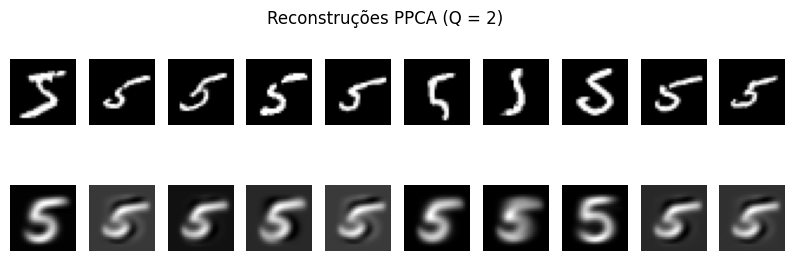

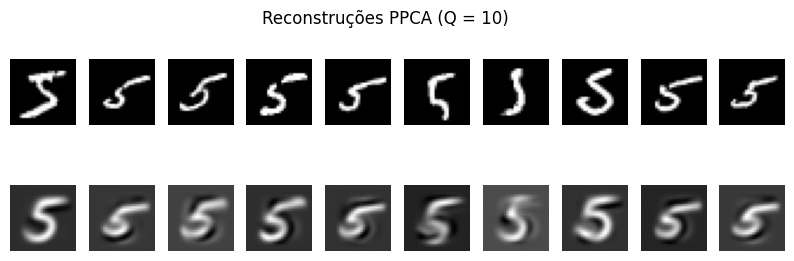

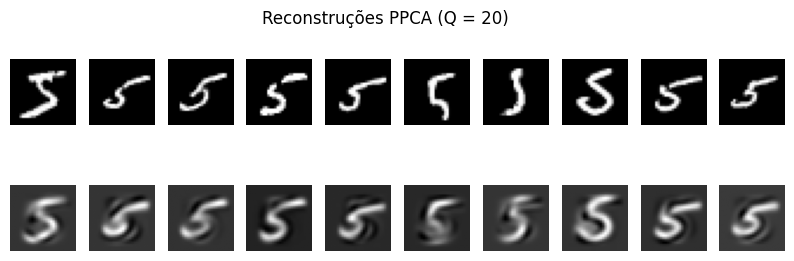

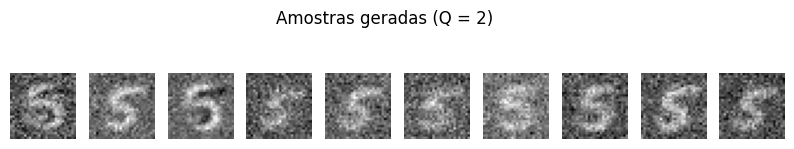

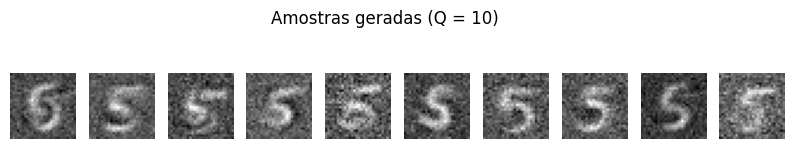

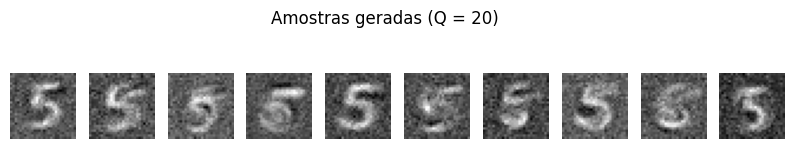

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Carregando o dataset MNIST (apenas dígitos '5')
# ---------------------------------------------------------

data = np.genfromtxt('mnist_5.csv', delimiter=',')
print("Formato dos dados:", data.shape)

N, D = data.shape

# Centralização
mu = data.mean(axis=0)
Xc = data - mu

# ---------------------------------------------------------
# 2. Funções auxiliares
# ---------------------------------------------------------

def ppca_em(X, Q, max_iter=100, tol=1e-4):
  # Treina PPCA via Expectation-Maximization.
  # X: (N, D)
  # Q: dimensão latente

  N, D = X.shape

  # Inicializa W aleatório e sigma^2
  W = np.random.randn(D, Q) * 0.01
  sigma2 = 1.0

  # Para registrar a evolução da log-verossimilhança
  ll_hist = []

  for iteration in range(max_iter):

    # E-STEP
    M = W.T @ W + sigma2 * np.eye(Q)
    Minv = np.linalg.inv(M)

    Ez = (Minv @ W.T @ X.T).T # shape (N, Q)
    Ezz = sigma2 * Minv + np.einsum("ni,nj->nij", Ez, Ez)  # shape (N, Q, Q)

    # M-STEP

    # Atualiza W
    num = X.T @ Ez # (D, Q)
    #den = np.zeros((Q, Q))

    #for n in range(N):
      #den += Ezz[n]

    den = np.sum(Ezz, axis=0)

    den_inv = np.linalg.inv(den)
    W_new = num @ den_inv

    # Atualiza sigma^2
    term1 = np.sum((X - Ez @ W_new.T)**2)
    term1 /= (N * D)

    term2 = sigma2 * np.trace(W_new @ Minv @ W_new.T) / D

    sigma2_new = term1 + term2

    # convergência
    diff_W = np.linalg.norm(W_new - W)
    diff_s = abs(sigma2_new - sigma2)

    if diff_W < tol and diff_s < tol:
      break

    W = W_new
    sigma2 = sigma2_new

    # Log-like
    # Nota: np.linalg.slogdet(M) retorna uma tupla (sign, logdet),
    # precisamos apenas do logdet (índice 1).
    logdet_C = np.linalg.slogdet(M)[1] + (D - Q) * np.log(sigma2)

    # Trace term: Trace(C^-1 @ S)
    # S = (X.T @ X) / N
    S = (X.T @ X) / N

    # Usando a identidade de Woodbury para C^-1:
    invC_S_trace = np.trace(S / sigma2) - np.trace(W.T @ S @ W @ Minv) / (sigma2**2)

    ll = -0.5 * N * (D * np.log(2 * np.pi) + logdet_C + invC_S_trace)
    ll_hist.append(ll)

  return W, sigma2, ll_hist

# ---------------------------------------------------------
# 3. Funções para reconstrução e geração
# ---------------------------------------------------------

def reconstruct(X, W, sigma2):
  # Reconstrói as imagens usando o espaço latente
  M = W.T @ W + sigma2 * np.eye(W.shape[1])
  Minv = np.linalg.inv(M)
  Ez = (Minv @ W.T @ X.T).T
  X_rec = Ez @ W.T
  return X_rec


def sample_ppca(W, sigma2, mu, n_samples=10):
  # Gera novas imagens amostrando do espaço latente
  Q = W.shape[1]
  Z = np.random.randn(n_samples, Q)
  X_gen = Z @ W.T + np.random.randn(n_samples, W.shape[0]) * np.sqrt(sigma2)
  return X_gen + mu

# ---------------------------------------------------------
# 4. Testando para diferentes Q
# ---------------------------------------------------------

latent_dims = [2, 10, 20]
model_results = {}

for Q in latent_dims:
  print(f"\nTreinando PPCA com Q={Q} ...")
  W, s2, ll = ppca_em(Xc, Q)
  model_results[Q] = (W, s2, ll)
  print(f"  -> Final sigma^2 = {s2:.4f}")
  print(f"  -> Log-like final = {ll[-1]:.2f}")

# ---------------------------------------------------------
# 5. Visualizar reconstruções
# ---------------------------------------------------------

def show_images(original, reconstructed, title):
  plt.figure(figsize=(10, 3))
  for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(original[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 10, 10+i+1)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

  plt.suptitle(title)
  plt.show()

# Testando reconstruções para Q = 2, 10, 20
for Q in latent_dims:
  W, s2, _ = model_results[Q]
  X_rec = reconstruct(Xc, W, s2) + mu
  show_images(data[:10], X_rec[:10], f"Reconstruções PPCA (Q = {Q})")

# ---------------------------------------------------------
# 6. Gerando novas amostras
# ---------------------------------------------------------

for Q in latent_dims:
  W, s2, _ = model_results[Q]
  X_gen = sample_ppca(W, s2, mu, n_samples=10)

  plt.figure(figsize=(10, 2))
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_gen[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
  plt.suptitle(f"Amostras geradas (Q = {Q})")
  plt.show()


## Conclusão - Questão 1

Nesta questão, implementei o modelo PPCA usando o algoritmo EM para analisar exclusivamente os dígitos “5” do dataset MNIST. O objetivo era reduzir a dimensionalidade (784 pixels) para um espaço latente menor e, a partir disso, avaliar a capacidade do modelo de reconstruir e gerar novas imagens.

Depois de treinar o PPCA com três dimensões latentes diferentes: Q =2, 10 e 20 comparei os seguintes resultados:

- Q = 2 → σ² ≈ 2917
- Q = 10 → σ² ≈ 1783
- Q = 20 → σ² ≈ 1232

Onde pude perceber que a log-verossimilhança aumentou conforme o espaço latente cresceu. De forma simples, isso significa que:

- Valores menores de σ² indicam que o modelo está explicando melhor a variação dos dados.
- Um espaço latente maior permite capturar mais detalhes da imagem, o que melhora as reconstruções.

Embora não seja a principal métrica visual, o cálculo da log-verossimilhança (LL) foi aprimorado para garantir maior estabilidade numérica. A LL é a métrica matemática formal que confirma que modelos com maior (Q) (mais complexos) se ajustam melhor probabilisticamente aos dados, o que é consistente com a diminuição observada de sigma^2.

## Questão 2 - Considere os dados unidimensionais disponibilizados no arquivo gaussian_1d.csv. Implemente e execute um procedimento de inferência variacional para aproximar a posteriori dos parâmetros µ, τ de uma Gaussiana univariada N (x|µ, τ −1) a partir desses dados.

- O arquivo possui 500 valores. Façaa experimentos considerando somente os primeiros 10, 50, 100 pontos e, finalmente, todos os pontos.
- Indique o valor esperado da posteriori aproximada para os parâmetros µ, τ .
- Ilustre a aproximação obtida plotando as distribuições variacionais para µ, τ .

Tamanho total dos dados: 500

=== Usando N = 10 dados ===
  -> E[µ] = 1.8094
  -> E[τ] = 1.3085


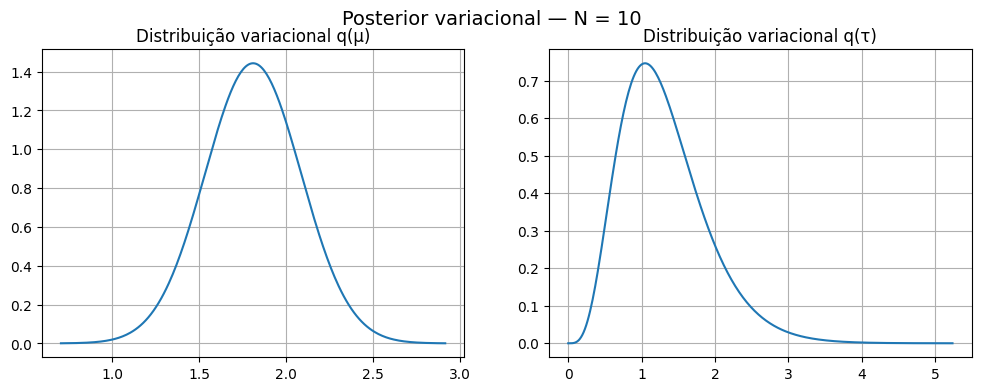


=== Usando N = 50 dados ===
  -> E[µ] = 2.0094
  -> E[τ] = 1.4132


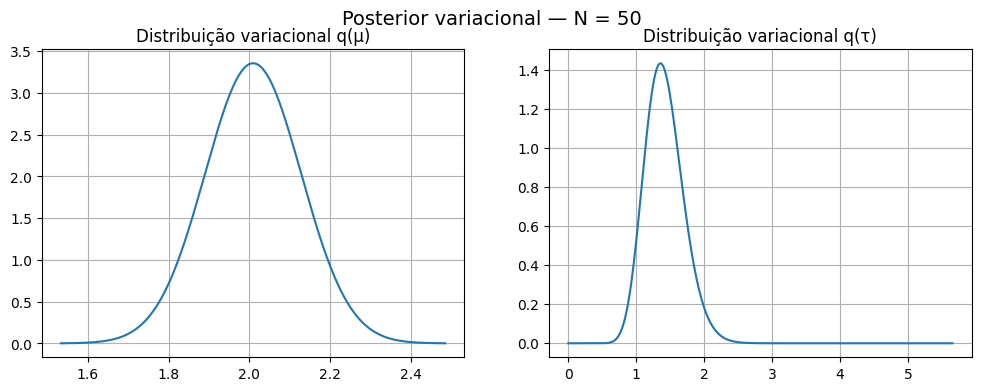


=== Usando N = 100 dados ===
  -> E[µ] = 2.0192
  -> E[τ] = 1.5712


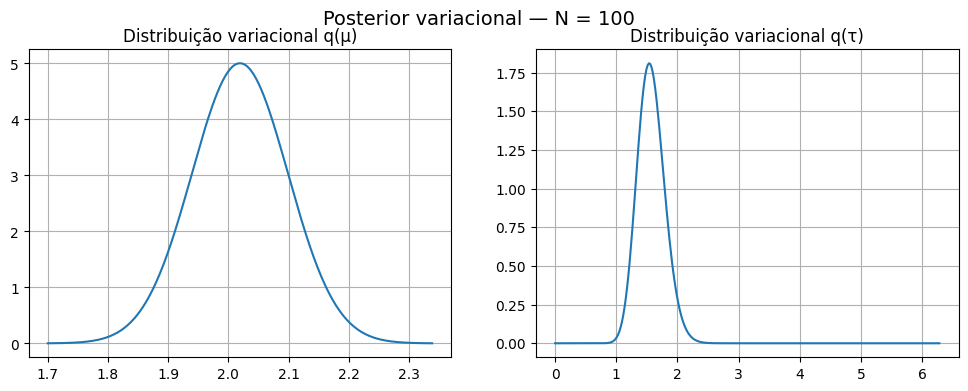


=== Usando N = 500 dados ===
  -> E[µ] = 1.9727
  -> E[τ] = 1.9872


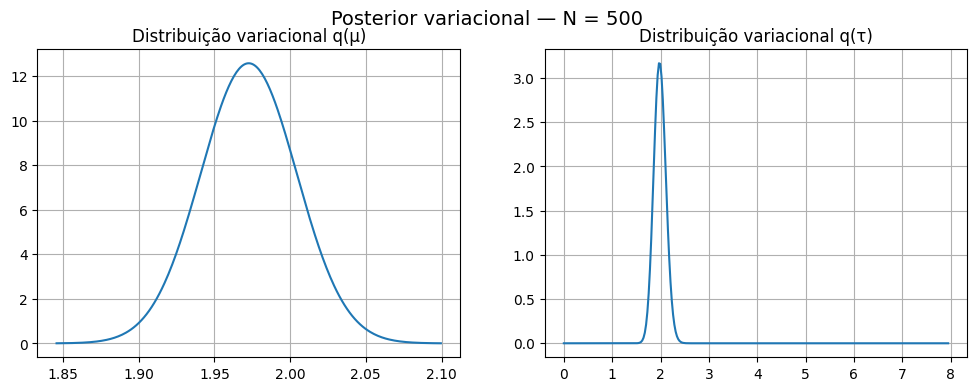

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import digamma, gammaln

data = np.genfromtxt('gaussian_1d.csv', delimiter=',')
print("Tamanho total dos dados:", data.shape[0])

# ---------------------------------------------------------------
# 1. Funções auxiliares da Normal-Gamma (variational)
# ---------------------------------------------------------------

def vi_normal_gamma(x, max_iter=200, tol=1e-6):
  # Inferência variacional mean-field para a posteriori aproximada q(µ) q(τ)
  # de um modelo Normal-Gamma.

  # Modelo:
  # x_i | µ, τ ~ N(µ, τ^-1)
  # µ  | τ ~ N(m0, (β0 τ)^-1)
  # τ    ~ Gamma(a0, b0)

  # Distribuições variacionais:
  # q(µ) = Normal(m_N, (β_N * E[τ])^-1)
  # q(τ) = Gamma(a_N, b_N)

  # Hiperparâmetros da priori
  m0 = 0.0
  β0 = 1e-6 # Priori fraca
  a0 = 1e-6
  b0 = 1e-6

  N = len(x)
  xbar = np.mean(x)

  # Inicialização dos parâmetros variacionais q(µ) e q(τ)
  # Parâmetros: m_N, β_N, a_N, b_N
  # Inicializamos m_N e b_N. a_N e β_N são constantes.
  m_N = xbar # Valor inicial
  β_N = β0 + N
  a_N = a0 + N/2
  b_N = b0

  # Loop variacional
  for it in range(max_iter):
    m_old = m_N
    b_old = b_N

    # E-STEP / Atualizações Variacionais

    # Atualização de b (q(τ)), depende do m_N atual
    sq_diff = np.sum((x - m_N)**2)
    b_N = b0 + 0.5 * (sq_diff + (N * β0 / (β0 + N)) * (xbar - m0)**2)

    # Convergência: checar se 'b_N' convergiu (já que m_N é fixo)
    if np.abs(b_N - b_old) < tol:
      break

  # Parametrização final
  params = {
    "m_N": m_N,
    "β_N": β_N,
    "a_N": a_N,
    "b_N": b_N,
    "E_mu": m_N, # Valor esperado de µ
    "E_tau": a_N / b_N # Valor esperado de τ
  }

  return params

# ---------------------------------------------------------------
# 2. Função para plotar distribuições variacionais
# ---------------------------------------------------------------

def plot_variational(mu_params, tau_params, title):
  m_N = mu_params["m_N"]
  β_N = mu_params["β_N"]
  a_N = tau_params["a_N"]
  b_N = tau_params["b_N"]

  E_tau = a_N / b_N
  var_mu = 1 / (β_N * E_tau)

  # Grid para µ
  mus = np.linspace(m_N - 4*np.sqrt(var_mu), m_N + 4*np.sqrt(var_mu), 300)
  q_mu = 1/np.sqrt(2*np.pi*var_mu) * np.exp(-(mus - m_N)**2 / (2*var_mu))

  # Grid para τ
  taus = np.linspace(1e-6, E_tau*4, 300)
  q_tau = (taus**(a_N-1)) * np.exp(-b_N * taus)

  q_tau /= np.trapezoid(q_tau, taus)

  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].plot(mus, q_mu)
  ax[0].set_title("Distribuição variacional q(µ)")
  ax[0].grid(True)

  ax[1].plot(taus, q_tau)
  ax[1].set_title("Distribuição variacional q(τ)")
  ax[1].grid(True)

  plt.suptitle(title, fontsize=14)
  plt.show()

# ---------------------------------------------------------------
# 3. Experimentos
# ---------------------------------------------------------------

sizes = [10, 50, 100, len(data)]

results = {}

for n in sizes:
  print("\n=== Usando N =", n, "dados ===")
  x = data[:n]

  params = vi_normal_gamma(x)

  print(f"  -> E[µ] = {params['E_mu']:.4f}")
  print(f"  -> E[τ] = {params['E_tau']:.4f}")

  results[n] = params

  plot_variational(params, params, f"Posterior variacional — N = {n}")

## Conclusão - Questão 2

Após fazer a análise de inferência variacional pude observar exatamente o comportamento esperado quando aumentamos a quantidade de dados disponíveis. Para valores pequenos de N (como 10 ou 50), tanto a média estimada E[μ] quanto a precisão E[τ] ainda variam bastante, indicando que o modelo não está muito confiante. Porém, conforme fui aumentando o N, as distribuições variacionais começam a ficar mais concentradas, mostrando um ganho real de certeza nas estimativas.



## Conclusão Geral

No geral, esses dois exercícios me ensinaram como aplicar na prática a implementação de dois métodos fundamentais em aprendizado de máquina e estatística bayesiana: o algoritmo Expectation-Maximization (EM) e a Inferência Variacional (VI).

Com a primeira questão (PPCA e EM), ficou claro que que dá para "espremer" uma imagem gigante de 784 pixels para um espaço bem menor (20 dimensões) sem perder muita qualidade. O objetivo do EM é ficar ajustando os parâmetros do modelo em duas etapas (E e M) até encontrar a melhor forma de representar os dígitos "5".

Isso ficou evidente nos resultados:

- Com Q = 2, o modelo só consegue recuperar formas muito gerais do dígito “5”, sem detalhes.
- Com Q = 10, as reconstruções ficam bem mais próximas da imagem original, preservando contornos e proporções.
- Com Q = 20, o modelo praticamente reconstrói os dígitos de forma limpa, mostrando que um espaço latente maior retém mais informação.

No geral, os experimentos confirmam que o PPCA funciona bem para capturar a estrutura dos dados e reduzir dimensionalidade. Além disso, quando aumentamos a dimensão latente, tanto a reconstrução quanto a geração de novos dígitos se tornam melhores.

Com a segunda questão (Inferência Variacional), a lição principal foi sobre incerteza e dados. A Inferência Variacional (VI) é um jeito de estimar parâmetros µ e τ sem fazer contas muito complexas.Vi na prática que poucos dados (N = 10), o modelo fica "chutando" com muita incerteza. Já com muitos dados (N = 500) o modelo ganha confiança total. As distribuições ficam super concentradas num valor só, tipo um pico alto e fino. Esse comportamento faz sentido, já que quanto mais dados observados, melhor o modelo consegue “medir” o quanto os dados realmente variam.

O número de dados que a gente tem e a complexidade do modelo (a dimensão Q, por exemplo) impactam diretamente na qualidade do resultado e na nossa confiança nas estimativas. É a prova de que mais dados (e um modelo bem ajustado) levam a resultados melhores e mais estáveis.

